# Power and Multiple Comparisons

We would like to test the effects of sample size and standard deviation on the ability to detect differences in the means of samples from different populations. We would also like to examine the effects of multiple comparisons.

In [4]:
#@title Imports
#@markdown Let's import our libraries we will use for this notebook.
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.8g}'.format

from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns

from IPython.display import display, HTML

In [5]:
def r_squared(df):
  mean_all = df.iloc[:,-1].mean()
  sst = np.sum((df.iloc[:,-1] - mean_all)**2)

  ssb = 0
  for grp in df.iloc[:,0].unique():
    grp_data = df[df.iloc[:,0] == grp]
    ssb += grp_data.shape[0] * (np.mean(grp_data.iloc[:,-1]) - mean_all)**2

  return ssb / sst

def rmse(df):
  ssw = 0
  for grp in df.iloc[:,0].unique():
    grp_data = df[df.iloc[:,0] == grp]
    ssw += np.sum((grp_data.iloc[:,-1] - np.mean(grp_data.iloc[:,1]))**2)

  N = df.shape[0]
  k = len(df.iloc[:,0].unique())

  return np.sqrt(ssw/(N-k))

def adj_r_squared(df):
  # Calculate Mean Square (Error)
  mse = rmse(df)**2

  # Calculate Mean Square (C Total)
  mean_response = np.mean(df.iloc[:,-1])
  mst = np.sum((df.iloc[:,-1] - mean_response)**2) / (df.shape[0] - 1)

  # Calculate Adjusted R-squared
  return 1 - mse / mst

## Experiment 1

We would like to start by generating four columns in a `DataFrame`. These four columns should contain 40 rows and be normally distributed accordingly:

* A - Mean 0, Standard Deviation 1
* B - Mean 0, Standard Deviation 3
* C - Mean 2, Standard Deviation 1
* D - Mean 2, Standard Deviation 3

Let's start by creating our `DataFrame`.

In [ ]:
data1 = pd.DataFrame()

Now, let's generate each column.

In [ ]:
data1['A'] = np.random.normal(0, 1, size=40)
data1['B'] = np.random.normal(0, 3, size=40)
data1['C'] = np.random.normal(2, 1, size=40)
data1['D'] = np.random.normal(2, 3, size=40)

Now let's take a look at our data!

In [ ]:
data1

,A,B,C,D
0,0.94266613,-3.9665631,4.4790655,1.2183306
1,-1.7337175,1.8376534,2.882088,4.8735575
2,0.017093898,-2.7763951,1.5693231,0.32556402
3,-0.95370902,-0.48622752,2.3574554,-1.2356277
4,-1.607804,3.4387763,1.7398656,2.2506894
5,1.5941541,1.8766829,2.6218955,0.4664273
6,-0.77845813,2.8813723,2.3926603,1.3555953
7,-1.2130313,-2.1134996,2.2150312,5.0202954
8,0.11822974,3.5655233,1.1405868,3.0250605
9,-1.1384386,3.0991878,3.9988938,1.515711


It may be helpful for us to have a melted version of our `DataFrame`; that is, stack the columns such that we are left with two columns (one for our treatment, and one for our response). This can be easily achieved with the `DataFrame.melt` method.

In [ ]:
data1_melt = data1.melt()

Let's see our melted `DataFrame`!


In [ ]:
data1_melt

,variable,value
0,A,0.94266613
1,A,-1.7337175
2,A,0.017093898
3,A,-0.95370902
4,A,-1.607804
...,...,...
155,D,1.180457
156,D,5.244363
157,D,1.8932878
158,D,1.896797


### ANOVA on all data

Let's start by plotting swarm plots for each of the columns in our `DataFrame`.

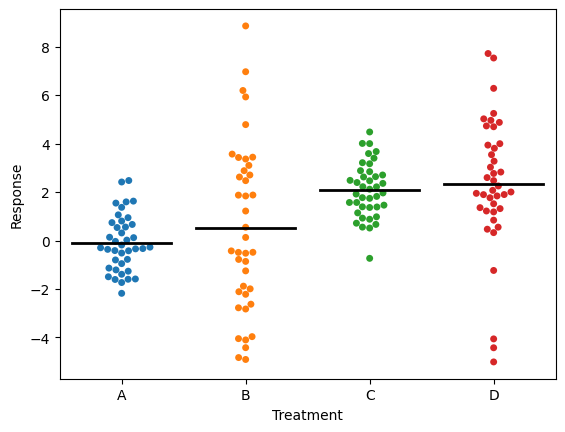

In [ ]:
fig = sns.swarmplot(data1)
fig.set(xlabel='Treatment', ylabel='Response')
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            data=data1,
            showfliers=False,
            showbox=False,
            showcaps=False,)
plt.show()

Let's calculate the summary of fit of our data. We will define a function, `summary_of_fit`, that we can use later.

In [ ]:
def summary_of_fit(df_melt):
  r_squared(data1_melt)

  sof_data = {
      'Rsquare': [r_squared(data1_melt)],
      'Adj Rsquare': [adj_r_squared(data1_melt)],
      'Root Mean Square Error': [rmse(data1_melt)],
      'Mean of Response': [data1_melt.iloc[:,-1].mean()],
      'Observations': [np.prod(data1.shape)],
  }
  return pd.DataFrame(sof_data).T

In [ ]:
display(HTML("<h2>Summary of Fit</h2>"))
display(summary_of_fit(data1_melt))

,0
Rsquare,0.16246767
Adj Rsquare,0.14636128
Root Mean Square Error,2.3580298
Mean of Response,1.2011849
Observations,160


Then, we can run an ANOVA on all the data (40 of each "treatment group"). Let's define another function, `analysis_of_variance`, that we can use later.

In [20]:
def analysis_of_variance(df_melt, df):
  f_result = stats.f_oneway(*[df[col] for col in df.columns])

  mean_all = df_melt.iloc[:,-1].mean()
  ssb = 0
  for grp in df_melt.iloc[:,0].unique():
    grp_data = df_melt[df_melt.iloc[:,0] == grp]
    ssb += grp_data.shape[0] * (np.mean(grp_data.iloc[:,-1]) - mean_all)**2

  ssw = 0
  for grp in df_melt.iloc[:,0].unique():
    grp_data = df_melt[df_melt.iloc[:,0] == grp]
    ssw += np.sum((grp_data.iloc[:,-1] - np.mean(grp_data.iloc[:,1]))**2)

  anova_data = {
    'Source': ['Treatment', 'Error', "C. Total"],
    'DF': [len(df.columns)-1, len(df_melt)-len(df.columns), len(df_melt)-1],
    'Sum of Squares': [ssb, ssw, ssb+ssw],
    'Mean Square': [ssb/(len(df.columns)-1),ssw/(len(df_melt)-len(df.columns)),""],
    'F Ratio': [f_result.statistic,"",""],
    'Prob > F': [f_result.pvalue if f_result.pvalue > 0.0001 else "<.0001","",""]
  }

  return pd.DataFrame(anova_data)


In [ ]:
display(HTML("<h2>Analysis of Variance</h2>"))
display(analysis_of_variance(data1_melt, data1))

,Source,DF,Sum of Squares,Mean Square,F Ratio,Prob > F
0,Treatment,3,168.26297,56.087657,10.087155,<.0001
1,Error,156,867.40753,5.5603047,,
2,C. Total,159,1035.6705,,,


And let's take a look at the means for our oneway ANOVA. Let's define the function `means_for_oneway_anova`.

In [ ]:
def means_for_oneway_anova(df_melt, df):
  means_data = {
      'Level': df.columns,
      'Number': [len(df[grp]) for grp in df],
      'Mean': [df[grp].mean() for grp in df],
      'Std Error': [rmse(df_melt)/np.sqrt(len(df[grp])) for grp in df],
      'Lower 95%': [stats.t.interval(
          0.95, #Confidence
          len(df_melt) - len(df.columns), #Deg freedom
          df[grp].mean(), #Grp mean
          rmse(df_melt)/np.sqrt(len(df[grp])))[0] #Grp std err
                    for i, grp in enumerate(df.columns)],
      'Upper 95%': [stats.t.interval(
          0.95, #Confidence
          len(df_melt) - len(df.columns), #Deg freedom
          df[grp].mean(), #Grp mean
          rmse(df_melt)/np.sqrt(len(df[grp])))[1] #Grp std err
                    for i, grp in enumerate(df.columns)],

  }


  return pd.DataFrame(means_data)


In [ ]:
display(HTML("<h2>Means for Oneway Anova</h2>"))
means_for_oneway_anova(data1_melt, data1)

,Level,Number,Mean,Std Error,Lower 95%,Upper 95%
0,A,40,-0.10103457,0.37283725,-0.83749534,0.6354262
1,B,40,0.5054997,0.37283725,-0.23096107,1.2419605
2,C,40,2.0756193,0.37283725,1.3391586,2.8120801
3,D,40,2.3246551,0.37283725,1.5881943,3.0611158


Now, the interesting part! If our P-value is significant, we can run Tukey-Kramer post-hoc analyses. Let's define our functions below, starting with `confidence_quantile`.

In [ ]:
def confidence_quantile(df_melt, df):
  df_within = len(df_melt) - len(df.columns)

  q_star = (1/np.sqrt(2))*stats.studentized_range.ppf(1-0.05,len(df.columns),df_within)

  q_data = {
      # q* = (1/sqrt(2))*q, where q = Alpha percentile of studentized range distribution
      'q*': [q_star],
      'Alpha': [0.05]

  }

  return pd.DataFrame(data=q_data)

In [ ]:
display(HTML("<h2>Confidence Quantile</h2>"))
display(confidence_quantile(data1_melt, data1))

,q*,Alpha
0,2.5969388,0.05


Now, let's define `hsd_threshold_matrix`.

In [ ]:
def hsd_threshold_matrix(df_melt, df):
  ssw = 0
  for grp in df_melt.iloc[:,0].unique():
    grp_data = df_melt[df_melt.iloc[:,0] == grp]
    ssw += np.sum((grp_data.iloc[:,-1] - np.mean(grp_data.iloc[:,1]))**2)

  MSw = ssw/(len(df_melt)-len(df.columns))

  pooled_n = len(df)

  hsd_matrix = np.zeros((len(df.columns), len(df.columns)))

  for i in range(hsd_matrix.shape[0]):
    for j in range(hsd_matrix.shape[1]):
      if i == j:
        pooled_n = 1/len(df[df.columns[i]])
      else:
        pooled_n = 0.5 * (1/len(df[df.columns[i]]) + 1/len(df[df.columns[j]]))
      mean_dif = np.abs(df[df.columns[i]].mean() - df[df.columns[j]].mean())
      hsd_matrix[i,j] = mean_dif - np.sqrt(MSw*pooled_n) * float(stats.studentized_range.ppf(1-0.05,len(df.columns), len(df_melt) - len(df.columns)))

  return pd.DataFrame(data=hsd_matrix, columns=df.columns, index=df.columns)

In [ ]:
display(HTML("<h2>HSD Threshold Matrix</h2>"))
display(hsd_threshold_matrix(data1_melt, data1))

,A,B,C,D
A,-1.3692918,-0.76275754,0.80736211,1.0563978
B,-0.76275754,-1.3692918,0.20082785,0.44986358
C,0.80736211,0.20082785,-1.3692918,-1.1202561
D,1.0563978,0.44986358,-1.1202561,-1.3692918


Now, let's define `connecting_letters_report`.

In [ ]:
## Insert code for connecting letters report (difficult!)

Finally, let's define `ordered_differences_report`.

In [ ]:
import itertools

combinations = list(itertools.combinations(grouped_data, 2))
level_combinations = list(itertools.combinations(data[X_name].unique(), 2))
index_combinations = list(itertools.combinations([i for i in range(len(grouped_data))], 2))

#Std Err Dif
# rmse(*grouped_data)/np.sqrt(len(combo[1])) - rmse(*grouped_data)/np.sqrt(len(combo[0]))



ord_data = {
    '(Level 1, Level 2)': [t for t in level_combinations],
    'Difference': [np.abs(t[0].mean() - t[1].mean()) for t in combinations],
    'Std Err Dif': [((rmse(*grouped_data)/np.sqrt(len(t[0])))**2 + (rmse(*grouped_data)/np.sqrt(len(t[1])))**2)**0.5 for t in combinations],
    'Lower CL': [0 for t in index_combinations],
    'Upper CL': [0 for t in index_combinations],
    'p-Value': [stats.tukey_hsd(*grouped_data).pvalue[t[0],t[1]] for t in index_combinations]
}

for i in range(len(combinations)):
  ord_data['Lower CL'][i] = ord_data['Difference'][i] - q_star * ord_data['Std Err Dif'][i]
  ord_data['Upper CL'][i] = ord_data['Difference'][i] + q_star * ord_data['Std Err Dif'][i]

ord_table = pd.DataFrame(data=ord_data)
ord_table = ord_table.sort_values('Difference', ascending=False)
ord_table.style.set_caption("Ordered Differences Report")

And, let's also define a plotting method for this report, `plot_ordered_differences`.

In [ ]:
ord_table2 = ord_table.sort_values('Difference', ascending=True)

for lower, center, upper,y in zip(ord_table2['Lower CL'],ord_table2['Upper CL'],ord_table2['Difference'],range(len(ord_table2))):
    plt.plot((lower,center, upper),(y,y,y),'bo-')
plt.yticks(range(len(ord_table2)),list(ord_table2['(Level 1, Level 2)']))
plt.title("Ordered Differences Report - Intervals")
plt.show()

## Experiment 2

For our second experiment, we would like to start by generating a column, labeled `Response`, in a `DataFrame`. This column should contain 100 rows drawn from a normal distributed with mean = 0 and standard deviation = 5.

Let's start by creating our `DataFrame`.

In [127]:
data2 = pd.DataFrame()

Now, let's create our `Response` column according to the aforementioned normal distribution.

In [128]:
data2['Response'] = np.random.normal(0, 5, size=100)

Le'ts take a look at our `DataFrame`.

In [129]:
data2

,Response
0,-4.4821689
1,-0.27983124
2,3.6407319
3,-1.1315977
4,12.867608
...,...
95,0.37574804
96,3.8084828
97,1.8423534
98,1.6394949


Next, we'd like to generate 30 columns with random integer values between 1 and 3 (these will serve as our factors).

In [130]:
for i in range(30):
  data2[f'Column {i+1}'] = [str(x) for x in np.random.randint(1,4, 100)]

Let's take a look at our `DataFrame` again!

In [131]:
data2

,Response,Column 1,Column 2,Column 3,Column 4,Column 5,Column 6,Column 7,Column 8,Column 9,...,Column 21,Column 22,Column 23,Column 24,Column 25,Column 26,Column 27,Column 28,Column 29,Column 30
0,-4.4821689,3,3,3,1,1,3,3,1,3,...,2,3,3,3,2,3,2,1,3,2
1,-0.27983124,2,3,2,1,2,2,3,3,2,...,3,2,1,2,2,2,3,2,1,3
2,3.6407319,1,3,2,1,1,3,3,2,1,...,2,1,3,2,1,1,3,1,1,2
3,-1.1315977,3,1,1,1,1,1,3,2,1,...,3,3,1,3,3,1,3,1,3,3
4,12.867608,3,1,1,3,1,2,1,2,1,...,1,2,2,2,3,3,3,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.37574804,2,3,2,1,1,3,2,1,2,...,3,1,2,1,2,1,3,2,1,2
96,3.8084828,3,1,2,1,2,2,3,2,2,...,2,3,2,3,1,1,2,2,2,3
97,1.8423534,1,3,3,1,3,1,1,3,3,...,2,3,1,3,3,3,2,3,2,2
98,1.6394949,3,2,3,2,2,2,2,3,1,...,2,1,3,3,1,1,3,2,1,3


Now, let's calculate the ANOVA P-values and populate them into a `DataFrame`! This way, we can see which results are statistically significant at ɑ = 0.05 (or other significance levels).

In [138]:
p_value_data = {
    'Column': [],
    'P-Value': []
}

for i in range(30):
  column = f'Column {i+1}'
  temp_df = data2[['Response', column]]
  f_result = stats.f_oneway(*[temp_df[temp_df[column] == val]['Response'] for val in temp_df[column].unique()])
  p_value_data['Column'].append(column)
  p_value_data['P-Value'].append(f_result.pvalue)

display(HTML("<h2>P-Values for 30 Columns</h2>"))
display(pd.DataFrame(p_value_data))

,Column,P-Value
0,Column 1,0.14104645
1,Column 2,0.8647267
2,Column 3,0.35866551
3,Column 4,0.16046164
4,Column 5,0.90828766
5,Column 6,0.84295247
6,Column 7,0.035382502
7,Column 8,0.48257839
8,Column 9,0.64319941
9,Column 10,0.92947402
